In [1]:
import requests
import datetime
import time
import pprint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import operator
from collections import Counter

CELLXGENE_DEV_ENDPOINT = 'https://api.cellxgene.dev.single-cell.czi.technology'
CELLXGENE_STAGING_ENDPOINT = 'https://api.cellxgene.staging.single-cell.czi.technology'
CELLXGENE_PRODUCTION_ENDPOINT = 'https://api.cellxgene.cziscience.com'

COLLECTIONS = "/dp/v1/collections/"
DOWNLOAD_DATASET = "/dp/v1/datasets/"

In [2]:
COLLECTIONS_REQUEST = CELLXGENE_PRODUCTION_ENDPOINT + COLLECTIONS

# get collections
r = requests.get(COLLECTIONS_REQUEST)
r.raise_for_status()

collections = r.json()["collections"]

In [14]:
# get information on each collection
def get_collection_data(collection_id):
    return requests.get(COLLECTIONS_REQUEST + collection_id).json()

collection_data = [get_collection_data(c["id"]) for c in collections]
collection_data = sorted(collection_data, key=operator.itemgetter("created_at"))

In [15]:
NUM_COLLECTIONS = len(collection_data)
print(NUM_COLLECTIONS)

30


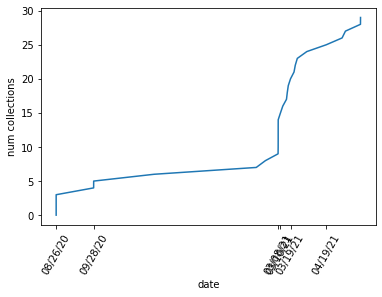

In [16]:
# create graph of collections (submissions) over time.
dates = np.array([c["created_at"] for c in collection_data])
date_tick_locs = dates[::5]
date_tick_labs = [datetime.datetime.fromtimestamp(d).strftime("%m/%d/%y") for d in date_tick_locs]

plt.plot(dates, np.arange(dates.shape[0]))
plt.ylabel("num collections")
plt.xlabel("date")
plt.xticks(ticks=date_tick_locs, labels=date_tick_labs, rotation=60);

In [17]:
datasets = []
for c in collection_data:
    datasets.extend(c["datasets"])

In [18]:
NUM_DATASETS = len(datasets)
print(NUM_DATASETS)

127


In [19]:
# build a dataframe of information from datasets

In [20]:
datasets[0].keys()

dict_keys(['assay', 'collection_id', 'collection_visibility', 'created_at', 'dataset_assets', 'dataset_deployments', 'development_stage', 'disease', 'ethnicity', 'id', 'linked_genesets', 'name', 'organism', 'processing_status', 'published', 'revision', 'sex', 'tissue', 'updated_at'])

In [21]:
def count_instances(datasets, field):
    instances = Counter()
    for d in datasets:
        for val in d[field]:
            instances[val["label"]] += 1
    return instances

In [22]:
assay_counts = count_instances(datasets, "assay")
disease_counts = count_instances(datasets, "disease")
ethnicity_counts = count_instances(datasets, "ethnicity")
tissue_counts = count_instances(datasets, "tissue")

organism_counts = Counter()
for d in datasets:
    organism_counts[d["organism"]["label"]] += 1

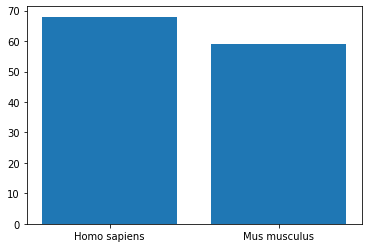

In [23]:
plt.bar(organism_counts.keys(), organism_counts.values());

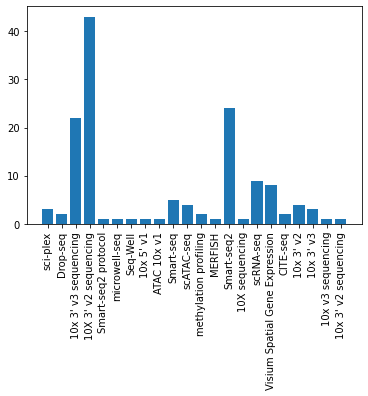

In [24]:
# we have cleanup to do on the assay metadata. How many ways can the same 10x assay be described? ;-) 
plt.bar(assay_counts.keys(), assay_counts.values());
plt.xticks(rotation=90);

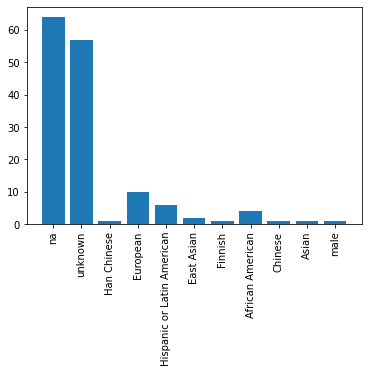

In [25]:
# we have cleanup to do on the assay metadata. How many ways can the same 10x assay be described? ;-) 
plt.bar(ethnicity_counts.keys(), ethnicity_counts.values());
plt.xticks(rotation=90);

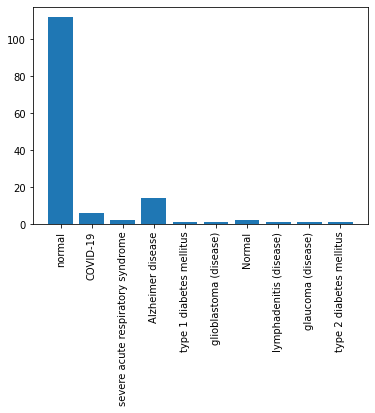

In [26]:
# we have cleanup to do on the assay metadata. How many ways can the same 10x assay be described? ;-) 
plt.bar(disease_counts.keys(), disease_counts.values());
plt.xticks(rotation=90);

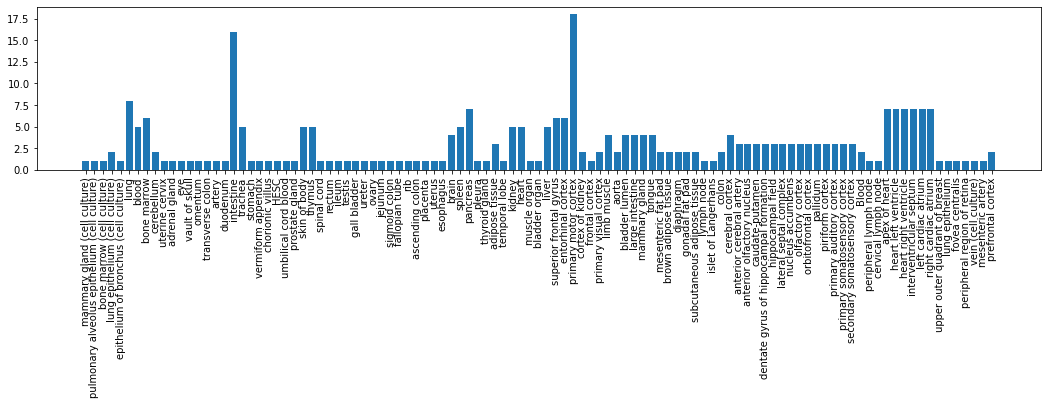

In [27]:
# this will need to be adjusted as our data corpus grows 
plt.subplots(figsize=(18, 3))
plt.bar(tissue_counts.keys(), tissue_counts.values());
plt.xticks(rotation=90);

In [28]:
NUM_CELLS = np.sum([d["cell_count"] if "cell_count" in d else 0 for d in datasets])
NUM_CELLS

5353484

In [41]:
dataset_df = pd.DataFrame(datasets)[["created_at", "cell_count"]]

In [46]:
dataset_df["month"] = [datetime.datetime.fromtimestamp(d).month for d in dataset_df["created_at"]]
dataset_df["year"] = [datetime.datetime.fromtimestamp(d).year for d in dataset_df["created_at"]]

In [50]:
cells_per_month = dataset_df.groupby(["month", "year"]).apply(sum)["cell_count"]
cells_per_month

In [54]:
datasets_per_year = dataset_df.groupby(["month", "year"]).count()["cell_count"]
datasets_per_year